In [1]:
import argparse
import os
import numpy as np
import math
import itertools
import sys
import glob
import random
from PIL import Image

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import cv2
from torchvision.models import vgg19

from tqdm import tqdm
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ESRGan/Real-ESRGAN

/content/drive/MyDrive/Colab Notebooks/ESRGan/Real-ESRGAN


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)


In [ ]:
class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.Conv2d(in_features, filters, 3, 1, 1, bias=True)]
            if non_linearity:
                layers += [nn.LeakyReLU()]
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x

In [ ]:
class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

In [ ]:
class GeneratorRRDB(nn.Module):
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2):
        super(GeneratorRRDB, self).__init__()

        # First layer
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # Second conv layer post residual blocks
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        # Upsampling layers
        upsample_layers = []
        for _ in range(num_upsample):
            upsample_layers += [
                nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(),
                nn.PixelShuffle(upscale_factor=2),
            ]
        self.upsampling = nn.Sequential(*upsample_layers)
        # Final output block
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return torch.clamp(tensors, 0, 255)


In [ ]:
def replace_value(slce_ds, slce):
  #max = slce.max()
  #return np.where(slce_ds==slce_ds.max(), slce.max(), slce_ds)
  max_org = slce.max()
  min_org = slce.min()
  max = slce_ds.max()
  min = slce_ds.min()
  for i in range(64):
    for j in range(64):
      if slce_ds[i][j]==max:
        slce_ds[i][j]=max_org
      elif slce_ds[i][j]==min:
        slce_ds[i][j]=min_org
  return slce_ds

In [ ]:
def getLR(hr_data):
    dim = (64,64)
    hr_data = hr_data[0,:,:]
    hr_data = np.squeeze(hr_data)
    imgfft = np.fft.fftn(hr_data)
    x_center = imgfft.shape[0] // 2
    y_center = imgfft.shape[1] // 2
    imgfft[x_center-100 : x_center+100, y_center-100 : y_center+100] = 0
    imgifft = np.fft.ifftn(imgfft)
    img_out = abs(imgifft)
    img_out = cv2.resize(img_out, dim, interpolation=cv2.INTER_LINEAR)
    img_out = replace_value(img_out, hr_data)
    img_out = img_out[np.newaxis,:,:]
    img_out = np.repeat(img_out, 3, axis=0)
    return img_out

In [ ]:
##normalized in range mean, std
class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.files = sorted(glob.glob(root + "/*.*"))
        self.hr_transform = transforms.Compose(
            [
                transforms.Normalize(mean, std),
            ]
        )

    def __getitem__(self, index):
        img1 = np.load(self.files[index % len(self.files)])
        img1 = np.squeeze(img1)
        img1 = img1[np.newaxis,:,:]
        img1 = np.repeat(img1, 3, axis=0)
        img1_tnsr = torch.from_numpy(img1).to(dtype=torch.float)
        img_hr = self.hr_transform(img1_tnsr)
        img1_lr = getLR(img1)
        img_lr = torch.from_numpy(img1_lr).to(dtype=torch.float)
        img_lr = self.hr_transform(img_lr)
        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=2, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="DIV2K_train_HR_sub_ADNI_BRATS_Frst", help="name of the dataset")
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--hr_height", type=int, default=256, help="high res. image height")
parser.add_argument("--hr_width", type=int, default=256, help="high res. image width")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between saving image samples")
parser.add_argument("--checkpoint_interval", type=int, default=500, help="batch interval between model checkpoints")
parser.add_argument("--residual_blocks", type=int, default=23, help="number of residual blocks in the generator")
parser.add_argument("--warmup_batches", type=int, default=500, help="number of batches with pixel-wise loss only")
parser.add_argument("--lambda_adv", type=float, default=5e-3, help="adversarial loss weight")
parser.add_argument("--lambda_pixel", type=float, default=1e-2, help="pixel-wise loss weight")
parser.add_argument("-f", "--file", required=False) 
opt = parser.parse_args()
print(opt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hr_shape = (opt.hr_height, opt.hr_width)

# Initialize generator and discriminator
generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(device)
discriminator = Discriminator(input_shape=(opt.channels, *hr_shape)).to(device)
feature_extractor = FeatureExtractor().to(device)

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)
criterion_pixel = torch.nn.L1Loss().to(device)

#if opt.epoch != 0:
# Load pretrained models
generator.load_state_dict(torch.load("saved_models_v2/generator_0.pth"))
print("Generator Loaded")
discriminator.load_state_dict(torch.load("saved_models_v2/discriminator_0.pth"))
print("Discriminator Loaded")

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

dataloader = DataLoader(
    ImageDataset("datasets/DIV2K/%s" % opt.dataset_name, hr_shape=hr_shape),
    batch_size=opt.batch_size,
    shuffle=True,
)

# ----------
#  Training
# ----------

for epoch in range(opt.epoch, opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        batches_done = epoch * len(dataloader) + i

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < opt.warmup_batches:
            # Warm-up (pixel-wise loss only)
            loss_pixel.backward()
            optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), loss_pixel.item())
            )
            continue

        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + opt.lambda_adv * loss_GAN + opt.lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
            % (
                epoch,
                opt.n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_content.item(),
                loss_GAN.item(),
                loss_pixel.item(),
            )
        )
        '''
        if batches_done % opt.sample_interval == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            img_grid = denormalize(torch.cat((imgs_lr, gen_hr), -1))
            save_image(img_grid, "images/training/%d.png" % batches_done, nrow=1, normalize=False)
        '''
        if batches_done % opt.checkpoint_interval == 0:
            # Save model checkpoints
            torch.save(generator.state_dict(), "saved_models_v2/generator_0.pth")
            torch.save(discriminator.state_dict(), "saved_models_v2/discriminator_0.pth")

In [ ]:
len(dataloader)

15744

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--checkpoint_model", type=str, default = "saved_models_v2/bk/generator_0.pth", help="Path to checkpoint model")
parser.add_argument("--channels", type=int, default=3, help="Number of image channels")
parser.add_argument("--residual_blocks", type=int, default=23, help="Number of residual blocks in G")
parser.add_argument("-f", "--file", required=False) 
opt = parser.parse_args()
print(opt)

Namespace(channels=3, checkpoint_model='saved_models_v2/bk/Copy of generator_0.pth', file='/root/.local/share/jupyter/runtime/kernel-2855430e-84d0-488c-8da1-426f1c7f3f55.json', image_path=None, residual_blocks=23)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model and load model checkpoint
generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(device)
generator.load_state_dict(torch.load(opt.checkpoint_model))
generator.eval()

GeneratorRRDB(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dense_blocks): Sequential(
        (0): DenseResidualBlock(
          (b1): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b2): Sequential(
            (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b3): Sequential(
            (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b4): Sequential(
            (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b5): Sequential(
            (0): Conv2d(320, 64, kernel_size=(3, 3), stride=

In [ ]:
hr_transform = transforms.Compose(
            [
                transforms.Normalize(mean, std),
            ]
)
#image_tensor = hr_transform(image_tensor)

In [ ]:
!pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=e7678700fcf8ebe54ec73dd0267299c2971ea07ea7c743a4c5388f8837d8b6c4
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [ ]:
#tests the model
input = 'inputs/BRATS_FFT_First'

if os.path.isfile(input):
    paths = [input]
else:
    paths = sorted(glob.glob(os.path.join(input, '*')))  
 
generated_esrgan = []
lq_image = []

for idx, path in enumerate(paths):
    imgname, extension = os.path.splitext(os.path.basename(path))
    print('Testing', idx, imgname)  
    img = np.load(path)
    img_sn = np.squeeze(img)
    lq_image.append(img_sn)
    img = img_sn[np.newaxis,:,:]
    img = np.repeat(img, 3, axis=0)
    img = img[np.newaxis,:,:,:]
    img1_tnsr = torch.from_numpy(img)
    image_tensor = Variable(img1_tnsr).to(device, dtype=torch.float)
    image_tensor = hr_transform(image_tensor)
    sr_image = denormalize(generator(image_tensor)).cpu()
    sr_test = sr_image.detach().numpy()
    sr_tes = sr_test[0,0,:,:]
    sr_tes = (sr_tes-np.min(sr_tes))/(np.max(sr_tes)-np.min(sr_tes))
    generated_esrgan.append(sr_tes)

In [ ]:
generated_esrgan = np.array(generated_esrgan)
lq_image = np.array(lq_image)

In [ ]:
#load the ground truth images
ground_truth = np.squeeze(np.load('results/BRATS_FFT_Original_Generated/ground_truth_brats.npy'))

In [ ]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
import math

from sklearn.metrics import mean_absolute_error as mae
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrm

def rmsdiff(im1, im2):
    """Calculates the root mean square error (RSME) between two images"""
    return math.sqrt(mse(im1, im2))
def nrmdiff(im1, im2):
    """Calculates the root mean square error (RSME) between two images"""
    return nrm(im1, im2, normalization='mean')
def mean_abs_err(im1, im2):
    return mae(im1, im2)


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import rescale
dim = (256, 256)

array_psnr = []
array_ssim = []
array_nrm = []
array_mae = []
array_vif = []

array_psnr_linear = []
array_ssim_linear = []
array_nrm_linear = []
array_mae_linear = []
array_vif_linear = []

array_psnr_cubic = []
array_ssim_cubic = []
array_nrm_cubic = []
array_mae_cubic = []
array_vif_cubic = []


for i in tqdm(range(len(ground_truth))):

  data_orig = ground_truth[i]
  data_lr = lq_image[i]
  data_lr = (data_lr-np.min(data_lr))/(np.max(data_lr)-np.min(data_lr))
  #The order of interpolation. The order has to be in the range 0-5:
  #       - 0: Nearest-neighbor
  #       - 1: Bi-linear (default)
  #       - 2: Bi-quadratic
  #       - 3: Bi-cubic
  #       - 4: Bi-quartic
  #       - 5: Bi-quintic
  x_temp_linear = rescale(data_lr, scale=(4, 4), order = 1)
  x_temp_linear = x_temp_linear.astype(np.float32)

  val_psnr_linear = psnr(data_orig, x_temp_linear, data_range = x_temp_linear.max() - x_temp_linear.min())
  val_ssim_linear = ssim(data_orig, x_temp_linear, data_range = x_temp_linear.max() - x_temp_linear.min())
 
  val_mae_linear = mean_abs_err(data_orig, x_temp_linear)
  val_nrm_linear = nrmdiff(data_orig, x_temp_linear)
  val_vif_linear = vifp(data_orig, x_temp_linear)

  x_temp_cubic = rescale(data_lr, scale=(4, 4), order = 3)
  x_temp_cubic = x_temp_cubic.astype(np.float32)

  val_psnr_cubic = psnr(data_orig, x_temp_cubic, data_range = x_temp_cubic.max() - x_temp_cubic.min())
  val_ssim_cubic = ssim(data_orig, x_temp_cubic, data_range = x_temp_cubic.max() - x_temp_cubic.min())
  val_mae_cubic = mean_abs_err(data_orig, x_temp_cubic)
  val_nrm_cubic = nrmdiff(data_orig, x_temp_cubic)
  val_vif_cubic = vifp(data_orig, x_temp_cubic)

  data_gen = generated_esrgan[i] 
  data_gen = (data_gen-np.min(data_gen))/(np.max(data_gen)-np.min(data_gen))
  data_gen = data_gen.astype(np.float32)

  val_psnr = psnr(data_orig, data_gen, data_range = data_gen.max() - data_gen.min())
  val_ssim = ssim(data_orig, data_gen, data_range = data_gen.max() - data_gen.min())
  val_mae = mean_abs_err(data_orig, data_gen)
  val_nrm = nrmdiff(data_orig, data_gen)
  val_vif = vifp(data_orig, data_gen)

  array_psnr_linear.append(val_psnr_linear)
  array_ssim_linear.append(val_ssim_linear)
  array_nrm_linear.append(val_nrm_linear)
  array_mae_linear.append(val_mae_linear)
  array_vif_linear.append(val_vif_linear)

  array_psnr_cubic.append(val_psnr_cubic)
  array_ssim_cubic.append(val_ssim_cubic)
  array_nrm_cubic.append(val_nrm_cubic)
  array_mae_cubic.append(val_mae_cubic)
  array_vif_cubic.append(val_vif_cubic)

  array_psnr.append(val_psnr)
  array_ssim.append(val_ssim)
  array_nrm.append(val_nrm)
  array_mae.append(val_mae)
  array_vif.append(val_vif)

100%|██████████| 7861/7861 [40:55<00:00,  3.20it/s]


In [ ]:
array_psnr_linear = np.array(array_psnr_linear)
array_ssim_linear = np.array(array_ssim_linear)
array_nrm_linear = np.array(array_nrm_linear)
array_mae_linear = np.array(array_mae_linear)
array_vif_linear = np.array(array_vif_linear)

array_psnr_cubic = np.array(array_psnr_cubic)
array_ssim_cubic = np.array(array_ssim_cubic)
array_nrm_cubic = np.array(array_nrm_cubic)
array_mae_cubic = np.array(array_mae_cubic)
array_vif_cubic = np.array(array_vif_cubic)

array_psnr = np.array(array_psnr)
array_ssim = np.array(array_ssim)
array_nrm = np.array(array_nrm)
array_mae = np.array(array_mae)
array_vif = np.array(array_vif)

In [ ]:
#1780 ADNI FFT first then linear interpolation 150k new iterations starting from no weights

print("The mean PSNR of model is " + str(array_psnr.mean()))
print("The mean SSIM of model is " + str(array_ssim.mean()))
print("The mean root mean square error of the model is " + str(array_nrm.mean()))
print("The mean absolute error of the model is " + str(array_mae.mean()))
print("The mean Visual Information Fidelity of the model is " + str(array_vif.mean()))

The mean PSNR of model is 26.762169780095387
The mean SSIM of model is 0.9170077408392063
The mean root mean square error of the model is 1.1894126817546122
The mean absolute error of the model is 0.016084416
The mean Visual Information Fidelity of the model is 0.6115850224116341


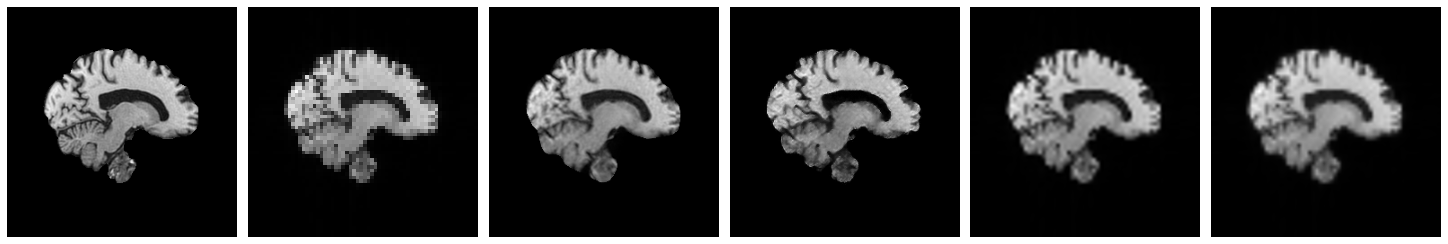

In [ ]:
#1780 ADNI FFT first then linear interpolation 150k esrgan 
from skimage.transform import rescale
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,6, figsize=(20,20), constrained_layout=True)
x = 1200
ax[0].imshow(ground_truth[x],cmap='gray')
ax[1].imshow(lq_image[x],cmap='gray')
ax[2].imshow(generated_realesrgan[x],cmap='gray',vmin=np.min(lq_image[x]), vmax= np.max(lq_image[x]))
ax[3].imshow(generated_esrgan[x],cmap='gray',vmin=np.min(lq_image[x]), vmax= np.max(lq_image[x]))
ax[4].imshow(rescale(lq_image[x], scale=(4, 4), order = 3),cmap='gray') #bi-cubic
ax[5].imshow(rescale(lq_image[x], scale=(4, 4), order = 1),cmap='gray') #bi-linear


for axes in ax.flatten():
  axes.axis('off')